![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 06: Market Basket Analysis and Recommender Systems
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Advanced Data Analysis (27-04-2020)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-advanced-data-analysis-2020/blob/master/S06_MBA/06_Advanced_Data_Analysis_MBA_TF_NOTsolved.ipynb)

**Resources (code patched and updated from):**
* O'Reilly library
* fast.ai


# Market Basket Analysis

## Simulation of Association Rule Metrics

UUID - #S6C1

In [0]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
current_palette = sns.color_palette()
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import  venn2
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from scipy.stats import fisher_exact
from ipywidgets import interact, IntSlider, FloatSlider

In [9]:
total_widget = IntSlider(min=10, max=2000, step=10, value=500)
antecedent_widget = IntSlider(min=5, max=2000, step=5, value=100)
consequent_widget = IntSlider(min=5, max=2000, step=5, value=100)
joint_widget = FloatSlider(min=.01, max=1.0, step=.01, value=.25)

def plot_metrics(antecedent, consequent, joint_percent, total):
    """Interactive Venn Diagram of joint transactions and plot of support, confidence, and lift  
        Slider Inputs:
            - total: total transactions for all itemsets
            - antecedent, consequent: all transactions involving either itemset
            - joint_percent: percentage of (smaller of) antecedent/consequent involving both itemsets

        Venn Diagram Calculations: 
            - joint = joint_percent * min(antecedent, consequent)
            - antecedent, consequent: original values - joint transactions

        Metric Calculations:
            - Support Antecedent: antecedent/total
            - Support Consequent: Consequent/total
            - Support Joint Transactions: joint/total
            - Rule Confidence: Support Joint Transactions / total
            - Rule Lift: Support Joint Transactions / (Support Antecedent * Support Consequent)
        """

    fig = plt.figure(figsize=(15, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0)) 
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0))
    ax4 = plt.subplot2grid((2, 2), (1, 1))
 
    
    joint = int(joint_percent * min(antecedent, consequent))
    
    contingency_table = [[joint, consequent - joint], [antecedent - joint, max(total - antecedent - consequent + joint, 0)]]
    contingency_df = pd.DataFrame(contingency_table, columns=['Consequent', 'Not Consequent'], index=['Antecedent', 'Not Antecedent']).astype(int)
    h = sns.heatmap(contingency_df, ax=ax1, annot=True, cmap='Blues', square=True, vmin=0, vmax=total, fmt='.0f')
    h.set_yticklabels(h.get_yticklabels(), rotation = 0)
    ax1.set_title('Contingency Table')
    
    v = venn2(subsets=(antecedent - joint, consequent - joint, joint),
              set_labels=['Antecedent', 'Consequent'],
              set_colors=current_palette[:2],
              ax=ax2)
    ax2.set_title("{} Transactions".format(total))

    support_antecedent = antecedent / total
    support_consequent = consequent / total

    support = pd.Series({'Antecedent': support_antecedent,
                         'Consequent': support_consequent})
    support.plot(kind='bar', ax=ax3,
                 color=current_palette[:2], title='Support', ylim=(0, 1), rot=0)
    ax3.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    support_joint = joint / total
    confidence = support_joint / support_antecedent
    lift = support_joint / (support_antecedent * support_consequent)

    _, pvalue = fisher_exact(contingency_table, alternative='greater')

    metrics = pd.Series(
        {'Confidence': confidence, 'Lift': lift, 'p-Value': pvalue})
    metrics.plot(kind='bar', ax=ax4,
                 color=current_palette[2:5], rot=0, ylim=(0, 2))
    ax3.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    for ax, series in {ax3: support, ax4: metrics}.items():
        rects = ax.patches
        labels = ['{:.0%}'.format(x) for x in series.tolist()]
        for rect, label in zip(rects, labels):
            height = min(rect.get_height() + .01, 2.05)
            ax.text(rect.get_x() + rect.get_width() / 2,
                    height, label, ha='center', va='bottom')

    plt.suptitle('Assocation Rule Analysis {Antecedent => Consequent}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

interact(plot_metrics,
         antecedent=antecedent_widget,
         consequent=consequent_widget,
         joint_percent=joint_widget,
         total=total_widget);

interactive(children=(IntSlider(value=100, description='antecedent', max=2000, min=5, step=5), IntSlider(value…

## The apriori algorithm

UUID - #S6C2

### Apyori library

Apyori is an easy and simple implementation of the apriori algorithm. It **does not incorporate the p-value thresholding**. Check the source code [here](https://github.com/ymoch/apyori/blob/master/apyori.py).

In [11]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-cp36-none-any.whl size=5975 sha256=037de8da575452af193b925e0e2603d61304b8133866c100e7130c3a77f31ed5
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori

#### Preprocessing the data from groceries

In [0]:
grocery_dataset = 'https://raw.githubusercontent.com/vfp1/bts-advanced-data-analysis-2020/master/S06_MBA/grocery_transactions.csv'

In [16]:
baskets = pd.read_csv(grocery_dataset, header=None)
baskets.iloc[:10, :10]

,0,1,2,3,4,5,6,7,8,9
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN
5,whole milk,butter,yogurt,rice,abrasive cleaner,NaN,NaN,NaN,NaN,NaN
6,rolls/buns,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,other vegetables,UHT-milk,rolls/buns,bottled beer,liquor (appetizer),NaN,NaN,NaN,NaN,NaN
8,potted plants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,whole milk,cereals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Let's replace empty values with 0
baskets.fillna(0,inplace=True)

In [37]:
baskets.iloc[:10, :10]

,0,1,2,3,4,5,6,7,8,9
0,citrus fruit,semi-finished bread,margarine,ready soups,0,0,0,0,0,0
1,tropical fruit,yogurt,coffee,0,0,0,0,0,0,0
2,whole milk,0,0,0,0,0,0,0,0,0
3,pip fruit,yogurt,cream cheese,meat spreads,0,0,0,0,0,0
4,other vegetables,whole milk,condensed milk,long life bakery product,0,0,0,0,0,0
5,whole milk,butter,yogurt,rice,abrasive cleaner,0,0,0,0,0
6,rolls/buns,0,0,0,0,0,0,0,0,0
7,other vegetables,UHT-milk,rolls/buns,bottled beer,liquor (appetizer),0,0,0,0,0
8,potted plants,0,0,0,0,0,0,0,0,0
9,whole milk,cereals,0,0,0,0,0,0,0,0


Our `DataFrame` shape is important, since we need to know how many rows do we have

In [38]:
baskets.shape

(9835, 32)

In [48]:
baskets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       9835 non-null   object
 1   1       9835 non-null   object
 2   2       9835 non-null   object
 3   3       9835 non-null   object
 4   4       9835 non-null   object
 5   5       9835 non-null   object
 6   6       9835 non-null   object
 7   7       9835 non-null   object
 8   8       9835 non-null   object
 9   9       9835 non-null   object
 10  10      9835 non-null   object
 11  11      9835 non-null   object
 12  12      9835 non-null   object
 13  13      9835 non-null   object
 14  14      9835 non-null   object
 15  15      9835 non-null   object
 16  16      9835 non-null   object
 17  17      9835 non-null   object
 18  18      9835 non-null   object
 19  19      9835 non-null   object
 20  20      9835 non-null   object
 21  21      9835 non-null   object
 22  22      9835 non-null   

#### Turning DataFrame into Apyori friendly format

Ayori expects that our dataset is in the form of a list of lists. The whole dataset should be a big list and each transaction in the dataset is an inner list within it.

So we need to convert our data into a list of lists.

In [0]:
records = []
for i in range(0, baskets.shape[0]):
    records.append([str(baskets.values[i,j]) for j in range(0, 20) if str(baskets.values[i,j])!='0'])

In [79]:
records

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product'],
 ['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner'],
 ['rolls/buns'],
 ['other vegetables',
  'UHT-milk',
  'rolls/buns',
  'bottled beer',
  'liquor (appetizer)'],
 ['potted plants'],
 ['whole milk', 'cereals'],
 ['tropical fruit',
  'other vegetables',
  'white bread',
  'bottled water',
  'chocolate'],
 ['citrus fruit',
  'tropical fruit',
  'whole milk',
  'butter',
  'curd',
  'yogurt',
  'flour',
  'bottled water',
  'dishes'],
 ['beef'],
 ['frankfurter', 'rolls/buns', 'soda'],
 ['chicken', 'tropical fruit'],
 ['butter', 'sugar', 'fruit/vegetable juice', 'newspapers'],
 ['fruit/vegetable juice'],
 ['packaged fruit/vegetables'],
 ['chocolate'],
 ['specialty bar'],
 ['other vegetables'],
 ['butter mi

#### Let's run Apyori 

Let's check the parameters involved in the apriori method. This is a copy of the GitHub repo containing the method.

In [0]:
# Do not run this! This comes from Apyori library. Just here for showing parameters and how do they work
def apriori(transactions, **kwargs):
    """
    Executes Apriori algorithm and returns a RelationRecord generator.
    Arguments:
        transactions -- A transaction iterable object
                        (eg. [['A', 'B'], ['B', 'C']]).
    Keyword arguments:
        min_support -- The minimum support of relations (float).
        min_confidence -- The minimum confidence of relations (float).
        min_lift -- The minimum lift of relations (float).
        max_length -- The maximum length of the relation (integer).
    """
    # Parse the arguments.
    min_support = kwargs.get('min_support', 0.1)
    min_confidence = kwargs.get('min_confidence', 0.0)
    min_lift = kwargs.get('min_lift', 0.0)
    max_length = kwargs.get('max_length', None)

    # Check arguments.
    if min_support <= 0:
        raise ValueError('minimum support must be > 0')

    # For testing.
    _gen_support_records = kwargs.get(
        '_gen_support_records', gen_support_records)
    _gen_ordered_statistics = kwargs.get(
        '_gen_ordered_statistics', gen_ordered_statistics)
    _filter_ordered_statistics = kwargs.get(
        '_filter_ordered_statistics', filter_ordered_statistics)

    # Calculate supports.
    transaction_manager = TransactionManager.create(transactions)
    support_records = _gen_support_records(
        transaction_manager, min_support, max_length=max_length)

    # Calculate ordered stats.
    for support_record in support_records:
        ordered_statistics = list(
            _filter_ordered_statistics(
                _gen_ordered_statistics(transaction_manager, support_record),
                min_confidence=min_confidence,
                min_lift=min_lift,
            )
        )
        if not ordered_statistics:
            continue
        yield RelationRecord(
            support_record.items, support_record.support, ordered_statistics)

#### Association Rules

In [0]:
association_rules = apriori(records, min_support=0.01, min_confidence=0.2, min_lift=1, max_length=3)
association_results = list(association_rules)

In [70]:
print(len(association_results))

171


In [73]:
print(association_results[0])

RelationRecord(items=frozenset({'whole milk'}), support=0.25551601423487547, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'whole milk'}), confidence=0.25551601423487547, lift=1.0)])


### MLXTEND Library

[Mlxtend](http://rasbt.github.io/mlxtend/) (machine learning extensions) is a Python library of useful tools for the day-to-day data science tasks. Check it out, it has some cool plotting and helper functions

In [0]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [0]:
records_mlx = records

#### Preprocessing for MLXTEND

Mlxtend needs a DataFrame in certain manner. Our *records* input works fine, if we treat it properly.

In [81]:
te = TransactionEncoder()
te_ary = te.fit(records_mlx).transform(records_mlx)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True,False,False,False,False,...,True,False,True,False,False,False,False,False,False,False,False,False,Fa

#### Running apriori on Mlxtend

In [82]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.033452,(UHT-milk)
1,0.017590,(baking powder)
2,0.052466,(beef)
3,0.033249,(berries)
4,0.026029,(beverages)
...,...,...
324,0.011998,"(tropical fruit, root vegetables, whole milk)"
325,0.014540,"(yogurt, root vegetables, whole milk)"
326,0.010371,"(soda, yogurt, whole milk)"
327,0.015150,"(yogurt, tropical fruit, whole milk)"


#### Running Association Rules with Mlxtend

The metrics you will get with this is **confidence** and **lift**. The `min_threshold` variable relates to the percentage above the level of **confidence**.

**Conviction** is a metric introduced which its value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1.

$\text{conviction}(A\rightarrow C) = \frac{1 - \text{support}(C)}{1 - \text{confidence}(A\rightarrow C)}, \;\;\; \text{range: } [0, \infty]$

In [84]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(beef),(whole milk),0.052466,0.255516,0.021251,0.405039,1.585180,0.007845,1.251315
1,(butter),(whole milk),0.055414,0.255516,0.027555,0.497248,1.946053,0.013395,1.480817
2,(butter milk),(whole milk),0.027961,0.255516,0.011591,0.414545,1.622385,0.004447,1.271634
3,(chicken),(other vegetables),0.042908,0.193493,0.017895,0.417062,2.155439,0.009593,1.383521
4,(chicken),(whole milk),0.042908,0.255516,0.017590,0.409953,1.604411,0.006627,1.261736
...,...,...,...,...,...,...,...,...,...
57,"(yogurt, rolls/buns)",(whole milk),0.034265,0.255516,0.015455,0.451039,1.765207,0.006700,1.356168
58,"(tropical fruit, root vegetables)",(whole milk),0.021047,0.255516,0.011998,0.570048,2.230969,0.006620,1.731553
59,"(yogurt, root vegetables)",(whole milk),0.025826,0.255516,0.014540,0.562992,2.203354,0.007941,1.703594
60,"(yogurt, tropical fruit)",(whole milk),0.029283,0.255516,0.015150,0.517361,2.024770,0.007668,1.542528


Filter by rules with other metrics

In [85]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(beef),0.193493,0.052466,0.019725,0.101944,1.943066,0.009574,1.055095
1,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416
2,(rolls/buns),(beef),0.183833,0.052466,0.013523,0.073562,1.402096,0.003878,1.022771
3,(beef),(rolls/buns),0.052466,0.183833,0.013523,0.257752,1.402096,0.003878,1.099588
4,(root vegetables),(beef),0.108998,0.052466,0.017387,0.159515,3.040367,0.011668,1.127366
...,...,...,...,...,...,...,...,...,...
521,"(yogurt, whole milk)",(whipped/sour cream),0.056024,0.071683,0.010880,0.194192,2.709053,0.006864,1.152033
522,"(whipped/sour cream, whole milk)",(yogurt),0.032232,0.139502,0.010880,0.337539,2.419607,0.006383,1.298943
523,(yogurt),"(whipped/sour cream, whole milk)",0.139502,0.032232,0.010880,0.077988,2.419607,0.006383,1.049627
524,(whipped/sour cream),"(yogurt, whole milk)",0.071683,0.056024,0.010880,0.151773,2.709053,0.006864,1.112881


#### Filter by items in DataFrame

In [88]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(other vegetables),(beef),0.193493,0.052466,0.019725,0.101944,1.943066,0.009574,1.055095,1
1,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416,1
2,(rolls/buns),(beef),0.183833,0.052466,0.013523,0.073562,1.402096,0.003878,1.022771,1
3,(beef),(rolls/buns),0.052466,0.183833,0.013523,0.257752,1.402096,0.003878,1.099588,1
4,(root vegetables),(beef),0.108998,0.052466,0.017387,0.159515,3.040367,0.011668,1.127366,1
...,...,...,...,...,...,...,...,...,...,...
521,"(yogurt, whole milk)",(whipped/sour cream),0.056024,0.071683,0.010880,0.194192,2.709053,0.006864,1.152033,2
522,"(whipped/sour cream, whole milk)",(yogurt),0.032232,0.139502,0.010880,0.337539,2.419607,0.006383,1.298943,2
523,(yogurt),"(whipped/sour cream, whole milk)",0.139502,0.032232,0.010880,0.077988,2.419607,0.006383,1.049627,1
524,(whipped/sour cream),"(yogurt, whole milk)",0.071683,0.056024,0.010880,0.151773,2.709053,0.006864,1.112881,1


In [90]:
rules[ (rules['antecedent_len'] >= 1) &
       (rules['confidence'] > 0.3) &
       (rules['lift'] > 1.2) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
1,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416,1
5,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628,1
6,(beef),(whole milk),0.052466,0.255516,0.021251,0.405039,1.585180,0.007845,1.251315,1
10,(berries),(other vegetables),0.033249,0.193493,0.010269,0.308869,1.596280,0.003836,1.166938,1
12,(berries),(whole milk),0.033249,0.255516,0.011795,0.354740,1.388328,0.003299,1.153774,1
...,...,...,...,...,...,...,...,...,...,...
510,"(soda, yogurt)",(whole milk),0.027250,0.255516,0.010371,0.380597,1.489523,0.003408,1.201938,2
514,"(yogurt, tropical fruit)",(whole milk),0.029283,0.255516,0.015150,0.517361,2.024770,0.007668,1.542528,2
516,"(tropical fruit, whole milk)",(yogurt),0.042298,0.139502,0.015150,0.358173,2.567516,0.009249,1.340701,2
520,"(yogurt, whipped/sour cream)",(whole milk),0.020742,0.255516,0.010880,0.524510,2.052747,0.005580,1.565719,2


#### Filter by entries based on antecedents or consequents

In [91]:
rules[rules['antecedents'] == {'tropical fruit', 'whole milk'}]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
451,"(tropical fruit, whole milk)",(other vegetables),0.042298,0.193493,0.017082,0.403846,2.087140,0.008898,1.352851,2
487,"(tropical fruit, whole milk)",(rolls/buns),0.042298,0.183833,0.010880,0.257212,1.399157,0.003104,1.098788,2
499,"(tropical fruit, whole milk)",(root vegetables),0.042298,0.108998,0.011998,0.283654,2.602365,0.007388,1.243814,2
516,"(tropical fruit, whole milk)",(yogurt),0.042298,0.139502,0.015150,0.358173,2.567516,0.009249,1.340701,2


#EXERCISE 1: best products from large baskets

UUID - #S6E1

Find the best products (those that has a consequent with high lift) from baskets larger than 4 items on the dataset given below.


---


***Part from Optional Exercise at home***

Also, and this is more complex, try to also threshold by pvalue. Apryori does not account for having a pvalue thresholding. Will you be able to filter results by pvalue?

In [0]:
exercise_csv = 'https://raw.githubusercontent.com/vfp1/bts-advanced-data-analysis-2020/master/S06_MBA/groceries_exercise.csv'

# Recommender systems 

Let's build a movie recommender system. Perhaps better than Netflix...

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Reshape,dot,Input,Dense
from keras.models import Sequential,Model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


## MovieLens 100k Dataset

UUID - #S6C3

In [3]:
!wget 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

--2020-04-27 05:40:21--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.49MB/s    in 0.6s    

2020-04-27 05:40:22 (1.49 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



### Unzipping downloaded data

In [0]:
import zipfile
with zipfile.ZipFile('/content/ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [0]:
data_dir = '/content/ml-latest-small/'

### Data Preprocessing

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
movie_ratings = pd.read_csv(data_dir + 'ratings.csv')
movie_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
movies = pd.read_csv(data_dir + 'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Check what the data is about

In [8]:
# Groupby user ID and its number of ratings
g = movie_ratings.groupby('userId')['rating'].count()

# Sort by the users with the highest number of ratings
top_users = g.sort_values(ascending=False)[:15]

# Groupby movieId and its number of ratings
g = movie_ratings.groupby('movieId')['rating'].count()

# Sort by the movies with the highest number of ratings
top_movies = g.sort_values(ascending=False)[:15]

# Join tables and due a crosstab
top_r = movie_ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


#### Encode the labels

In [9]:
# Encode users
user_enc = LabelEncoder()
movie_ratings['user'] = user_enc.fit_transform(movie_ratings['userId'].values)

# Get the total number of users
n_users = movie_ratings['user'].nunique()

# Encode movies
item_enc = LabelEncoder()
movie_ratings['movie'] = item_enc.fit_transform(movie_ratings['movieId'].values)

# Get the number of movies
n_movies = movie_ratings['movie'].nunique()

# Create the minimum rating and the maximum rating
movie_ratings['rating'] = movie_ratings['rating'].values.astype(np.float32)
min_rating = min(movie_ratings['rating'])
max_rating = max(movie_ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

#### Split data into XY

In [10]:
X = movie_ratings[['user', 'movie']].values
y = movie_ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

#### Decide on the number of factors

Decide on number of factors and create X_train, X_test tuples. Tuples consist of user and movie.

In [0]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

### Define and train the model

In [0]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout

In [0]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

##### Build a recommender with no activation

In [0]:
def Recommender_NoActivation(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [19]:
model = Recommender_NoActivation(n_users, n_movies, n_factors)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

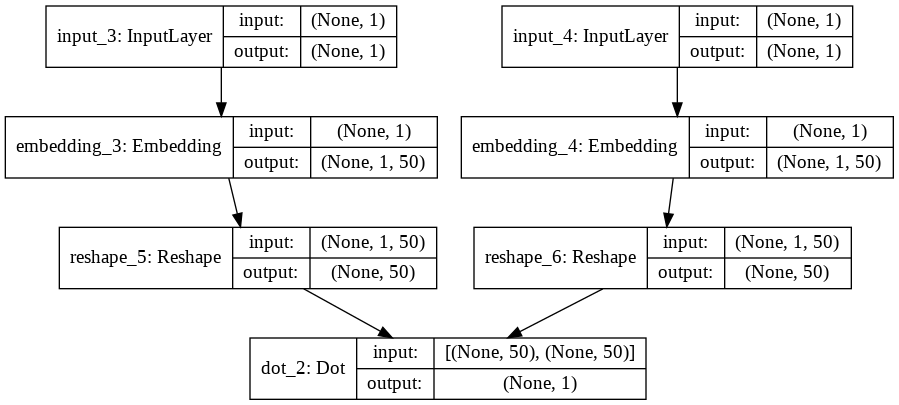

In [20]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 9s 94us/step - loss: 9.3636 - val_loss: 3.2159
Epoch 2/5
90752/90752 [==============================] - 8s 92us/step - loss: 1.9748 - val_loss: 1.6257
Epoch 3/5
90752/90752 [==============================] - 8s 91us/step - loss: 1.1169 - val_loss: 1.3482
Epoch 4/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.8564 - val_loss: 1.2598
Epoch 5/5
90752/90752 [==============================] - 9s 98us/step - loss: 0.7232 - val_loss: 1.2323


##### Build a recommender with activation



In [0]:
def Recommender_WithActivation(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Dot(axes=1)([u, m])

    # Adding activation
    x = Activation('sigmoid')(x)
    # Scale the results using min and max ratings of the dataset
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [25]:
model_activation = Recommender_WithActivation(n_users, n_movies, n_factors)
model_activation.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        30500       input_7[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        486200      input_8[0][0]                    
____________________________________________________________________________________________

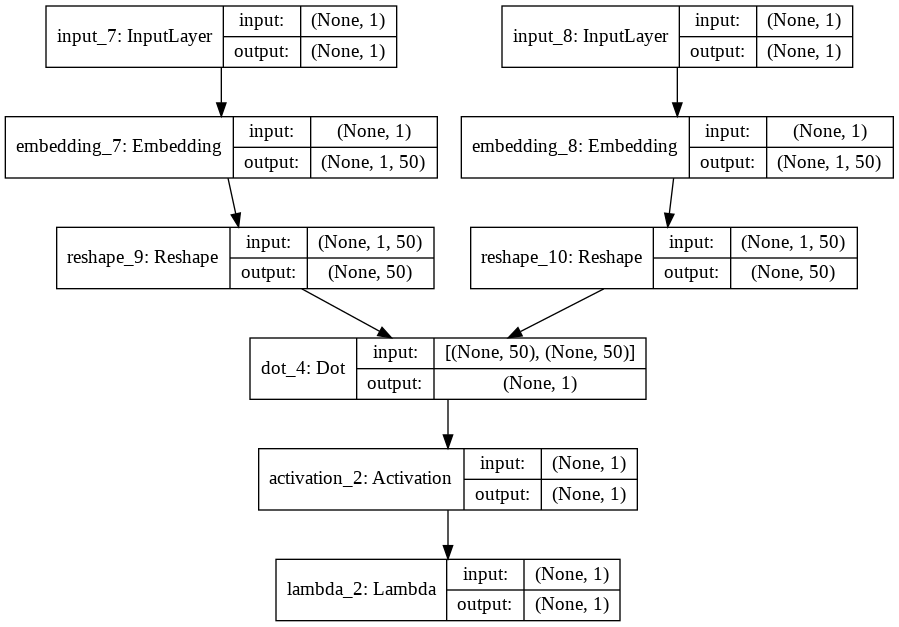

In [26]:
plot_model(model_activation, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
history = model_activation.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 8s 93us/step - loss: 1.3772 - val_loss: 0.9297
Epoch 2/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.7604 - val_loss: 0.8036
Epoch 3/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.5794 - val_loss: 0.7746
Epoch 4/5
90752/90752 [==============================] - 8s 92us/step - loss: 0.4519 - val_loss: 0.7737
Epoch 5/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.3581 - val_loss: 0.7821


##### Taking onto a NN approach

In [0]:
def Recommender_NN(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    # Use concatenate instead of Dot. Now we have an MLP!!!
    x = Concatenate()([u, m])
    # Add Dropout
    x = Dropout(0.05)(x)
    
    # Add a Dense layer, Activation and Dropout
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Add the output Dense layer equal to 1
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)

    # Add the scaled results
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [32]:
model_neural = Recommender_NN(n_users, n_movies, n_factors, min_rating, max_rating)
model_neural.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 50)        30500       input_11[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        486200      input_12[0][0]                   
____________________________________________________________________________________________

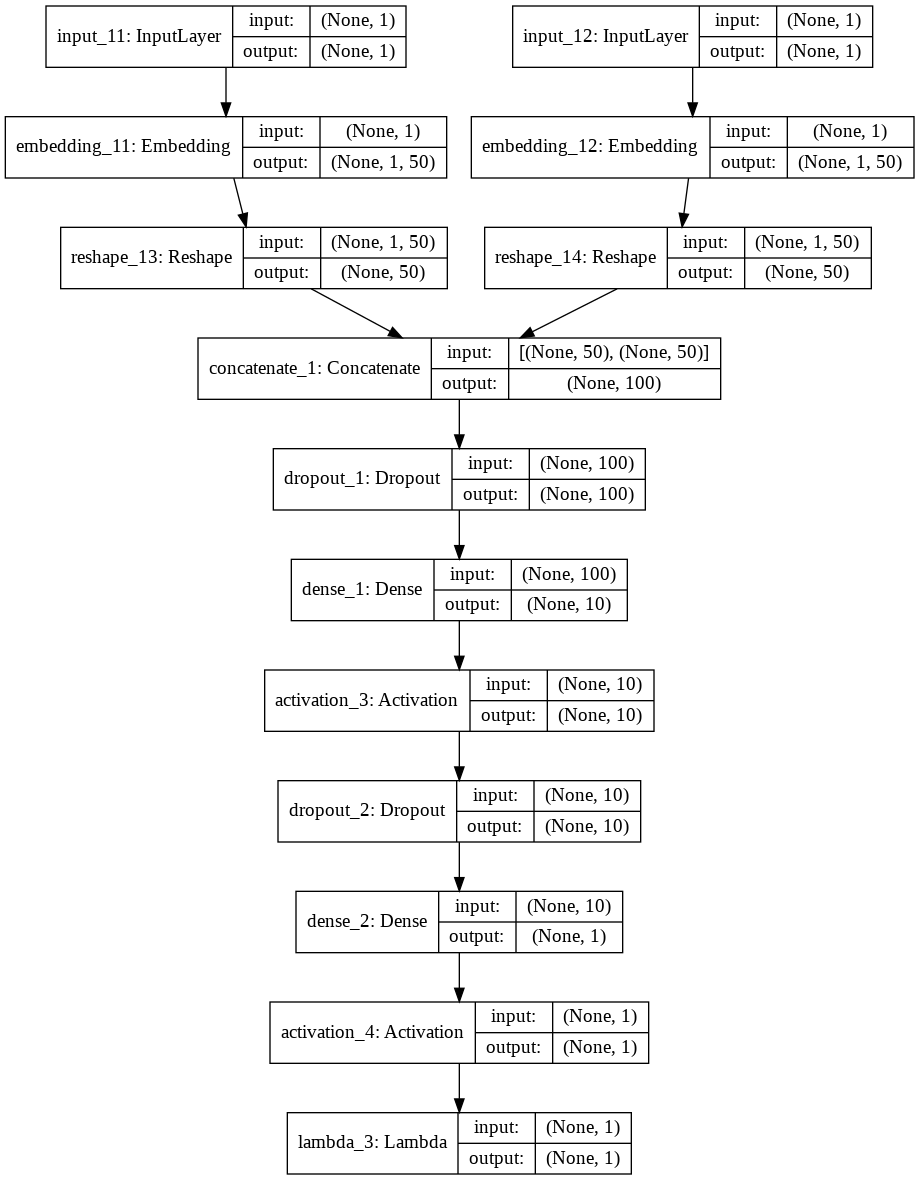

In [33]:
plot_model(model_neural, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
history = model_activation.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 8s 93us/step - loss: 1.3772 - val_loss: 0.9297
Epoch 2/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.7604 - val_loss: 0.8036
Epoch 3/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.5794 - val_loss: 0.7746
Epoch 4/5
90752/90752 [==============================] - 8s 92us/step - loss: 0.4519 - val_loss: 0.7737
Epoch 5/5
90752/90752 [==============================] - 8s 91us/step - loss: 0.3581 - val_loss: 0.7821


### Predicting the dataset

In [224]:
prediction_array = model.predict(X_test_array)
prediction_array

array([[2.761946 ],
       [3.3998868],
       [2.9437993],
       ...,
       [3.1780345],
       [2.5255682],
       [3.2166016]], dtype=float32)

In [210]:
movies.loc[movies['movieId']  == movies['movieId'][X_test[23][1]], 'title']

6294    Jesus Camp (2006)
Name: title, dtype: object

#### Creating a new dataframe with predictions

In [0]:
df_predictions = movies.join(movie_ratings.set_index('movieId'), on='movieId')

df_predictions = df_predictions.drop(['timestamp', 'user', 'movie'], axis=1)



In [0]:
pred_list = [(x[0], float(y)) for x, y in zip(X_test, prediction_array)]

In [264]:
pred_list_df = pd.DataFrame(pred_list, columns=['movieId', 'predictions'])
pred_list_df.head()

,movieId,predictions
0,431,2.761946
1,287,3.399887
2,598,2.943799
3,41,3.860840
4,74,3.269800


In [0]:
df_predictions_final = df_predictions.join(pred_list_df.set_index('movieId'), on='movieId').dropna()


In [268]:
df_predictions_final

,movieId,title,genres,userId,rating,predictions
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,3.657969
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,3.927455
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,3.657969
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,3.927455
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,3.657969
...,...,...,...,...,...,...
521,609,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children,527.0,4.0,4.746761
521,609,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children,527.0,4.0,5.056446
521,609,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children,527.0,4.0,4.125043
521,609,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children,527.0,4.0,3.405096


# EXERCISE 2: adding more features

UUID - #S6E2

Improve this recommendation system by adding movie genre and timestamp embeddings. As well, try to bring the cavalry with the MLP part, with all what you have learned. Also, try to use callbacks and TensorBoard for EarlyStopping and Visualization